In [1]:
#!g1.1
%pip install rouge_score -q
%pip install transformers -q
%pip install nltk -q
%pip install wandb -q

In [2]:
import gdown
import shutil

In [4]:
gdown.download('https://drive.google.com/file/d/1ubFv7uDAPVAD16vECVCL7cqzXQZclG3_/view?usp=share_link', 'formula_images.zip', quiet = False, fuzzy = True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1ubFv7uDAPVAD16vECVCL7cqzXQZclG3_
From (redirected): https://drive.google.com/uc?id=1ubFv7uDAPVAD16vECVCL7cqzXQZclG3_&confirm=t&uuid=f27465e9-0ca4-4f74-94b7-61a7b7f6caa3
To: /home/nikolay_kalm/EDA_OCR/DL/ImageToLatex/formula_images.zip
100%|██████████| 850M/850M [00:05<00:00, 155MB/s]  


'formula_images.zip'

In [5]:
gdown.download('https://drive.google.com/file/d/1FqQHsHhDHu3GG0hsla2v-5isDIQGNuVj/view?usp=share_link', 'im2latex_dataset_map.df.pkl.zip', quiet = False, fuzzy = True)

Downloading...
From: https://drive.google.com/uc?id=1FqQHsHhDHu3GG0hsla2v-5isDIQGNuVj
To: /home/nikolay_kalm/EDA_OCR/DL/ImageToLatex/im2latex_dataset_map.df.pkl.zip
100%|██████████| 11.9M/11.9M [00:00<00:00, 39.2MB/s]


'im2latex_dataset_map.df.pkl.zip'

In [7]:
shutil.unpack_archive('formula_images.zip')

In [8]:
shutil.unpack_archive('im2latex_dataset_map.df.pkl.zip')

In [9]:
!pip install einops

  Using cached einops-0.6.1-py3-none-any.whl (42 kB)


In [11]:
#!g1.1
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from einops import rearrange
import math
import cv2
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms as T
from torchvision.transforms import functional as F
from transformers import AutoTokenizer
import pandas as pd
from PIL import Image
import wandb
from torchvision.models import resnet101
from rouge_score import rouge_scorer

/home/nikolay_kalm/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
#!g1.1
!wandb login

wandb: Currently logged in as: nickcalmykow281. Use `wandb login --relogin` to force relogin


In [13]:
#!g1.1
tokenizer = AutoTokenizer.from_pretrained('nlpconnect/vit-gpt2-image-captioning')

In [14]:
#!g1.1
df = pd.read_pickle('im2latex_dataset_map.df.pkl')
df

,image,formula_name,latex
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,\int _ { - \epsilon } ^ { \infty } d l \: \mat...
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,d s ^ { 2 } = ( 1 - { \frac { q c o s \theta }...
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,\widetilde \gamma _ { \mathrm { h o p f } } \s...
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \..."
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...
...,...,...,...
154939,bdf0210244a0cd3_basic.png,bdf0210244a0cd3_basic,"D _ { g } ^ { g } ( \xi , Y ) | _ { D L } = \b..."
154940,f09875fed00506d_basic.png,f09875fed00506d_basic,\left( \begin{array} { l l } { M _ { \tilde { ...
154941,0d49cda875fc56c_basic.png,0d49cda875fc56c_basic,g ^ { 4 } \int { \frac { d ^ { 4 } p } { ( 2 \...
154942,db23b0939638460_basic.png,db23b0939638460_basic,E ( R ) \! = \! 2 \pi \! \! \int _ { 0 } ^ { \...


In [15]:
#!g1.1
df.latex = df.latex.apply(lambda x: '$' + x + '$')

In [16]:
#!g1.1
df

,image,formula_name,latex
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,$\int _ { - \epsilon } ^ { \infty } d l \: \ma...
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,$d s ^ { 2 } = ( 1 - { \frac { q c o s \theta ...
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,$\widetilde \gamma _ { \mathrm { h o p f } } \...
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"$( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ ..."
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,$S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ {...
...,...,...,...
154939,bdf0210244a0cd3_basic.png,bdf0210244a0cd3_basic,"$D _ { g } ^ { g } ( \xi , Y ) | _ { D L } = \..."
154940,f09875fed00506d_basic.png,f09875fed00506d_basic,$\left( \begin{array} { l l } { M _ { \tilde {...
154941,0d49cda875fc56c_basic.png,0d49cda875fc56c_basic,$g ^ { 4 } \int { \frac { d ^ { 4 } p } { ( 2 ...
154942,db23b0939638460_basic.png,db23b0939638460_basic,$E ( R ) \! = \! 2 \pi \! \! \int _ { 0 } ^ { ...


In [27]:
#!g1.1
class CustomDataset(Dataset):
    
    
    def __init__(self, data, tokenizer, transform = None, max_length = 150):
        
        self.data = data 
        
        self.tok = tokenizer
        
        self.transform = transform
        
        self.max_length = max_length
        
    def __len__(self):
        
        return len(self.data)
    
    
    def __getitem__(self, index):
            
        cur_row = self.data.iloc[index]
        
        x = Image.open(os.path.join(f'formula_images/{cur_row.image}'))
        
        y = self.tok(cur_row.latex, return_tensors = 'pt', max_length = self.max_length, 
                           add_special_tokens = False, truncation = True, padding = 'max_length')['input_ids'].squeeze()

        if self.transform is not None:
            
            x = self.transform(x)
            
        return x, y

In [28]:
#!g1.1
max_length = 150
dataset = CustomDataset(df, tokenizer, T.Compose([T.ToTensor(), T.Resize(size = (224, 224))]), max_length = max_length)

In [29]:
#!g1.1

batch_size = 20

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [30]:
#!g1.1
from torch.utils.data import Subset

In [31]:
#!g1.1
import random
ids = list(range(len(dataset)))
random.shuffle(ids)
train_ids = ids[:train_size]
test_ids = ids[train_size:]

train_dataset = Subset(dataset, train_ids)
val_dataset = Subset(dataset, test_ids)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [34]:
#!g1.1
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [35]:
#!g1.1

def compute_metrics(preds, labels):
    metrics = ['precision', 'recall', 'fmeasure']
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
    scores = scorer.score(''.join(pred_str), ''.join(labels_str))
    
    
    return {f'{key}_{metrics[idx]}': score for key in scores for idx, score in enumerate(scores[key])}


@torch.no_grad()
def generate_batch(model, img, is_decode = False):
    
    model.eval()
    img = img.to(device)
    
    N = img.shape[0]
    symbols = torch.tensor([3], device = device).expand(N, 1)
    
    for _ in range(max_length - 1):
        
        cur_symbols = model(img, symbols).argmax(-1)[:, -1][:, None]
        symbols = torch.cat([symbols, cur_symbols], dim = 1)
        
    if is_decode:
        symbols = tokenizer.batch_decode(symbols, skip_special_tokens=True)
    return symbols

In [36]:
#!g1.1
class CnnEncoder(nn.Module):
    
    def __init__(self, model, in_ch = 1, emd_size = 512, is_set_grad = True):
        super().__init__()
        self.model = model(pretrained = True)
        self.model.conv1 = nn.Conv2d(in_ch, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model  = nn.Sequential(*list(self.model.children())[:-2])
        
        
        self.last_conv = nn.Conv2d(2048, emd_size, kernel_size = 1)
        if is_set_grad:
            self.set_grad()
        
    def forward(self, x):
        
        x = self.model(x)
        
        x = self.last_conv(x)
        
        x = x.flatten(2).permute(0, 2, 1)
        
        return x
    
    def set_grad(self):
        
        for param in self.model.parameters():
    
            param.requires_grad_(False)
        
        for param in self.model[0].parameters():
    
            param.requires_grad_(True)
        
        for param in self.last_conv.parameters():
            
            param.requires_grad_(True)
        
    
    
        

In [37]:
#!g1.1

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # print(attn_scores.shape)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output
    

class EncoderLayer(torch.nn.Module):
    
    def __init__(self, dim, n_heads, dropout = 0.1):
        super().__init__()
        
        self.sa = MultiHeadAttention(dim, n_heads)
        
        self.ffn = nn.Sequential(
            nn.Linear(dim, 4*dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4*dim, dim),
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)
    
    def forward(self, x):
        
        x = x + self.ln1(self.sa(x, x, x))
        x = x + self.ln2(self.ffn(x))
#         x = x + self.sa(self.ln1(x))
#         x = x + self.ffn(self.ln2(x))
        
        return x
  


class ViTEncoder(nn.Module):
    
    def __init__(self, emd_size, n_heads, n_blocks, patch_size = 16, is_conv = False):
        super().__init__()
        self.is_conv = is_conv
        
        if not self.is_conv:
            
            self.lp_src = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
                nn.LayerNorm(patch_size**2),
                nn.Linear(patch_size**2, emd_size),
                nn.LayerNorm(emd_size),
            )
            self.pos_src = nn.Parameter(torch.randn(1, 14**2, emd_size))
        else:
            self.lp_src = nn.Conv2d(1, emd_size, kernel_size=patch_size, stride=patch_size)
        
        
        
        self.encoder_blocks = nn.Sequential(
            *[EncoderLayer(emd_size, n_heads) for _ in range(n_blocks)]
        )
        
    def forward(self, x):
        
        
        x = self.lp_src(x)


        if not self.is_conv:
            x = x + self.pos_src
            
        
        for block in self.encoder_blocks:
            x = block(x)
            
        return x
        
        
        
        

class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout = 0.1):
        
        super().__init__()
        
        self.cross_att = MultiHeadAttention(d_model, num_heads)
        self.masked_att = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
     
        
    def forward(self, x, enc_output):
        
        N, seq_length, _ = x.shape
        
#         masked_att = self.masked_att(x, x, x, mask = torch.tril(torch.ones(seq_length, seq_length,device=device)))
        masked_att = self.masked_att(x, x, x, mask = torch.tril(torch.ones(seq_length, seq_length)).expand(N, 1, seq_length, seq_length).to(device))
        x = self.norm1(x + self.dropout(masked_att))
        
        cross_mask = self.cross_att(x, enc_output, enc_output)
        x = self.norm2(x + self.dropout(cross_mask))
        
        ff_out = self.ffn(x)
        
        x = self.norm3(x + self.dropout(ff_out))
        
        return x
   
class Decoder(nn.Module):
    
    def __init__(self, emd_size, n_heads, n_blocks):
        super().__init__()
        
        
        self.lp_tgt = nn.Embedding(vocab_size, emd_size)
        self.pos_tgt = nn.Embedding(max_length, emd_size)
        
        self.decoder_blocks = nn.Sequential(
            *[DecoderLayer(emd_size, n_heads) for _ in range(n_blocks)]
        )
        
    def forward(self, tgt, src):
        
        tgt = self.lp_tgt(tgt)
        
        tgt += self.pos_tgt(torch.arange(tgt.shape[1], device=device).expand(tgt.shape[0], tgt.shape[1]))
        
        for block in self.decoder_blocks:
            tgt = block(tgt, src)
            
        return tgt
        
        
        
    

  
class Transformer(torch.nn.Module):
    
    def __init__(self, emd_size, hidden_size, n_heads, n_blocks, max_length, patch_size = 16, is_resnet = False):
        super().__init__()
        
        
        self.lp_src = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_size**2),
            nn.Linear(patch_size**2, emd_size),
            nn.LayerNorm(emd_size),
        )

        self.lp_tgt = nn.Embedding(vocab_size, emd_size)
        
        
        
        self.pos_src = nn.Parameter(torch.randn(1, 14**2, emd_size))
        
        self.pos_tgt = nn.Embedding(max_length, emd_size)
        
        
        self.max_length = max_length

        self.encoder_blocks = nn.Sequential(
            *[EncoderLayer(emd_size, n_heads) for _ in range(n_blocks)]
        )
        
        self.decoder_blocks = nn.Sequential(
            *[DecoderLayer(emd_size, n_heads) for _ in range(n_blocks)]
        )

        self.mlp = nn.Sequential(
            
            nn.Linear(emd_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, vocab_size)
        )
        

        
    def forward(self, src, tgt): #, tgt):
        
        
        src = self.lp_src(src)


        tgt = self.lp_tgt(tgt)

        src = src + self.pos_src

        
        tgt += self.pos_tgt(torch.arange(tgt.shape[1], device=device).expand(tgt.shape[0], tgt.shape[1]))
        
        for block in self.encoder_blocks:
            src = block(src)

          
        for block in self.decoder_blocks:
            tgt = block(tgt, src)
    
        tgt = self.mlp(tgt)
        
        return tgt

    

        

In [ ]:
#!g1.1
def generate(model, img):
    
    model.eval()
    img = img.to(device)
    img = img.unsqueeze(0)
    
    symbols = torch.tensor([[3]], device = device)

    for i in range(max_length - 1):
        cur_symb = model(img, symbols).argmax(2)[:,-1].unsqueeze(0)

        symbols = torch.cat([symbols, cur_symb], dim = 1)
    
    return tokenizer.decode(symbols[0].cpu(), skip_special_tokens = True)

In [39]:
#!g1.1
class Transformer(torch.nn.Module):
    
    def __init__(self, emd_size, hidden_size, n_heads, n_blocks, max_length, patch_size = 16, is_resnet = True):
        super().__init__()
        
    
        self.resnet = is_resnet
        
        if self.resnet:
            self.encoder = CnnEncoder(resnet101, emd_size = emd_size)
        
        else:
            self.encoder = ViTEncoder(emd_size, n_heads, n_blocks, patch_size)
        
        
        self.decoder = Decoder(emd_size, n_heads, n_blocks)
        

        self.mlp = nn.Sequential(
            
            nn.Linear(emd_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, vocab_size)
        )
        

        
    def forward(self, src, tgt):
        
        
        src = self.encoder(src)
        
        tgt = self.decoder(tgt, src)
        
        tgt = self.mlp(tgt)
        
        return tgt

In [40]:
#!g1.1
emd_size = 512
hidden_size = 512
n_heads = 64
n_blocks = 6

model_parameters = {
    'emd_size':emd_size,
    'hidden_size' :hidden_size,
    'n_heads':n_heads,
    'n_blocks':n_blocks,
    'max_length': max_length
}

vocab_size = len(tokenizer)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(emd_size, hidden_size, n_heads, n_blocks, max_length).to(device)

/home/nikolay_kalm/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nikolay_kalm/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/nikolay_kalm/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 158MB/s]  


In [41]:
#!g1.1
a = torch.randn(size = (1, 1, 224, 224), device = device)
b = torch.randint(0, vocab_size, size = (1, max_length),device = device)

In [42]:
#!g1.1
model(a,b).shape

torch.Size([1, 150, 50257])

In [43]:
#!g1.1
wandb.finish()

In [44]:
#!g1.1
wandb.init(
    
    project="imgToLatex",
    
    
    config={
        **model_parameters, 'max_length' : max_length, 'lr': 1e-4
    },

    name = f'CNN Encoder PreTrained'


)

In [45]:
#!g1.1
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = wandb.config['lr'])

In [48]:
#!g1.1
from tqdm.auto import tqdm
def epoch_train(model, criterion, optim, loader, device):
    
    model.train()
    n_correct = 0
    loss_total = 0
    rang = tqdm(loader)
    for idx, (img, labels) in enumerate(rang):
        cleanup()
        N = img.shape[0]
        img = img.to(device)
        labels = labels.to(device)
        outputs = model(img, labels[:,:-1])

        loss = criterion(outputs.view(N * (max_length - 1), -1), labels[:,1:].reshape(-1))

        loss_total+=loss.item()
        if idx % 2 == 0:   
            optim.zero_grad()
        loss.backward()
        optim.step()
        
        rang.set_description(f'Loss: {loss.item():.3f}')
        
        
        if (idx + 1) % (100) == 0:
            metrics = compute_metrics(generate_batch(model, img), labels)
            wandb.log({
                'loss_train': loss.item(),
                **metrics, 
            })
        
    return 0, loss_total/(len(loader))

@torch.no_grad()
def epoch_test(model, loader, criterion, device):
    
    model.eval()
    n_correct = 0
    loss_total = 0
    rang = tqdm(loader)
    
    for img, labels in rang:
        cleanup()
        N = img.shape[0]
        img = img.to(device)
        labels = labels.to(device)
        outputs = model(img, labels[:,:-1])
        
        loss = criterion(outputs.view(N * (max_length - 1), -1), labels[:,1:].reshape(-1))
        
        loss_total += loss.item()
        
        rang.set_description(f'Loss: {loss.item():.3f}')
            
    return 0, loss_total/(len(loader))

def train(model, criterion, optim, train_loader, test_loader, epochs, device):
    
    acc_train_list, loss_train_list = [], []
    acc_test_list, loss_test_list = [], []
    
    for epoch in tqdm(range(epochs)):
        
        
        acc_train, loss_train = epoch_train(model, criterion, optim, train_loader, device)
        acc_test, loss_test = epoch_test(model, test_loader,criterion, device)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        
        loss_train_list.append(loss_train)
        loss_test_list.append(loss_test)
        
        
#         print(f'Epoch {epoch+1}/{epochs}: Acc_train - {acc_train:.3f}, Loss_train - {loss_train:.3f}'+\
#              f' Acc_test - {acc_test:.3f}, Loss_test - {loss_test:.3f}')
    return acc_train_list, loss_train_list, acc_test_list, loss_test_list

In [62]:
#!g1.1
acc_train_list, loss_train_list, acc_test_list, loss_test_list = train(model, criterion, 
                                                          optim, 
                                                          train_loader = train_dataloader, 
                                                          test_loader = val_dataloader, 
                                                          epochs=5, 
                                                          device = device)

 20%|██        | 1/5 [2:03:35<8:14:22, 7415.59s/it]


KeyboardInterrupt: 

In [ ]:
#!g1.1
model_parameters = {
    'emd_size':emd_size,
    'hidden_size' :hidden_size,
    'n_heads':n_heads,
    'n_blocks':n_blocks,
    'max_length': max_length
}


torch.save(model.state_dict(), 'model/transformer_subset2.pt')
torch.save(model_parameters, 'model/model_parameters_subset2.pt')

In [ ]:
#!g1.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m = torch.load('model/transformer2.pt')
model_par = torch.load('model/model_parameters2.pt')

model = Transformer(**model_par).to(device)

model.load_state_dict(m)

<All keys matched successfully>

In [85]:
#!g1.1
model.eval()
img, tar = train_dataset[15]
img = img.to(device)
img = img.unsqueeze(0)
    
symbols = torch.tensor([[3]], device = device)

for i in range(max_length - 1):
    cur_symb = model(img, symbols).argmax(2)[:,-1].unsqueeze(0)
        
    symbols = torch.cat([symbols, cur_symb], dim = 1)

tokenizer.decode(symbols[0].cpu(), skip_special_tokens = True)

'$Q _ { \\pm } = \\frac { 1 } { 2 \\pi } \\int d ^ { 2 } x \\, \\epsilon _ { \\mu \\nu } \\partial _ { \\mu } x ^ { \\nu }.$'

In [86]:
#!g1.1
tokenizer.decode(tar, skip_special_tokens = True)

'$Q _ { 1, 2 } \\equiv \\frac 1 { 2 \\pi i } \\oint d z \\, \\, S _ { 1, 2 } \\left( z \\right)$'

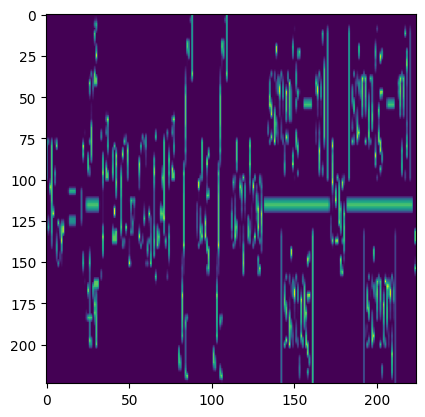

In [57]:
#!g1.1
plt.imshow(img.cpu()[0][0])